In [1]:
# constants
sample_rate = 80e6 # Known to work in range 40e6 - 80e6
fft_size = 8192
time_axis_averaging = 8
time_per_frame = (1/sample_rate) * (fft_size*time_axis_averaging)

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import SoapySDR
from SoapySDR import *  # SOAPY_SDR_ constants
import sys
from skimage.exposure import exposure

def plot_spectrogram(im):
    """ Uses rescaling to improve the dynamics. 
    Note that the input is not in dB format, but it does not matter too much!
    """
    im = np.array(im)
    p2, p98 = np.percentile(im, (1, 99.9))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))
    
    plt.figure(figsize = (9.75, 10))
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
def plot_fft(single_fft):
    """ Plot single frame from the spectrogram.
    Also converts to decibels!
    """
    
    plt.figure(figsize = (9.75, 5))
    plt.plot(np.log10(single_fft) * 10)
    plt.tight_layout()
    plt.grid()
    plt.show()


# Setup the Remote SDR interface

In [3]:
sdr_device = SoapySDR.Device({'driver': 'remote', 'cacheCalibrations': '1'}) # cacheCalibrations makes Lime interface faster, see https://github.com/myriadrf/LimeSuite/issues/200
sdr_device.setAntenna(SOAPY_SDR_RX, 0, 'LNAH')
sdr_device.setSampleRate(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setBandwidth(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setDCOffsetMode(SOAPY_SDR_RX, 0, True)

gains = {"LNA": 0, "TIA": 0, "PGA": -12}
for gain, value in gains.items():
    sdr_device.setGain(SOAPY_SDR_RX, 0, gain, value)

rx_stream = sdr_device.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CS16, [0],
                    {'remote:mtu': '2120', 'remote:prot': 'tcp'})

def get_batch(center_frequency, duration_sec):
    sdr_device.setFrequency(SOAPY_SDR_RX, 0, center_frequency)
    frames = int(duration_sec // time_per_frame)
    rx_buff = np.empty(shape=(frames, 512), dtype=np.int32)
    sdr_device.activateStream(rx_stream)
    for i in range(frames):
        sr = sdr_device.readStream(rx_stream, [rx_buff[i]], 512)
        if sr.ret != 512:
            print('Bad samples from remote!')
    
    sdr_device.deactivateStream(rx_stream)
    # convert to floats and rescale
    ret = rx_buff.astype(float) * 2**-43
    return ret

In [4]:
batch = get_batch(2440e6, 1)

<IPython.core.display.Javascript object>


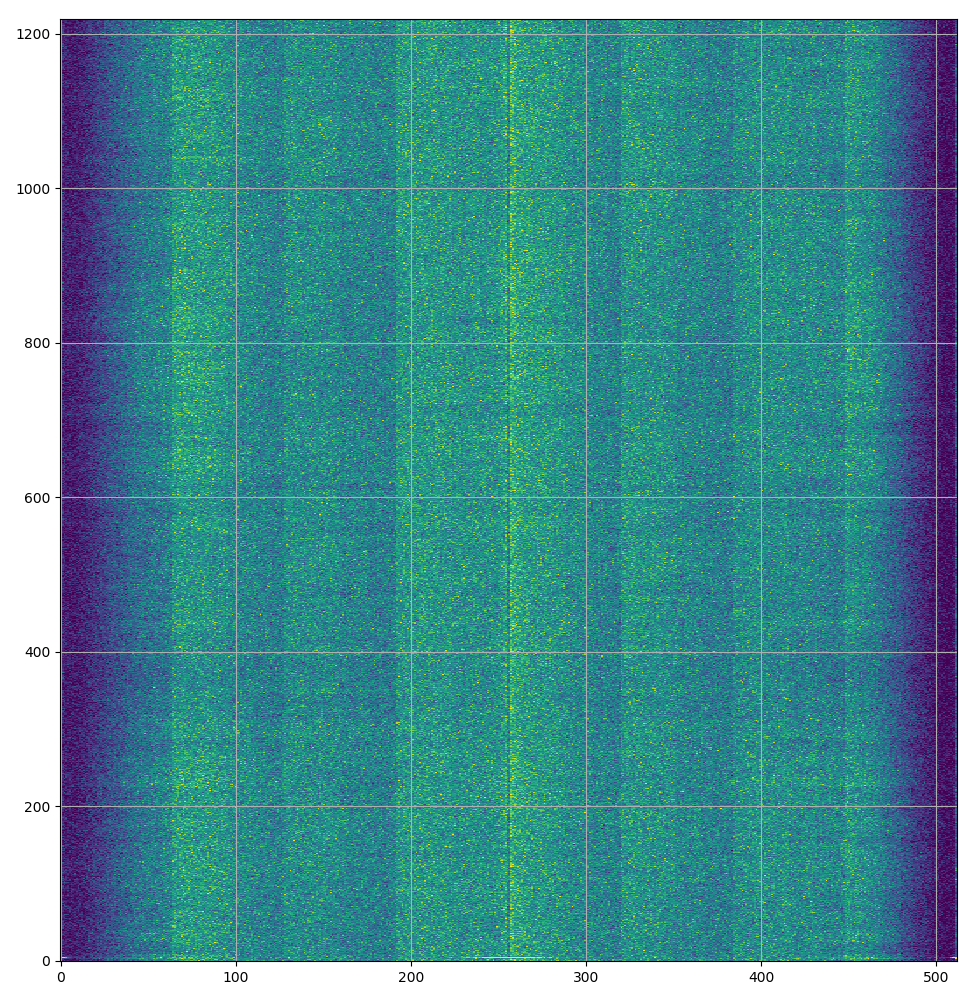

In [5]:
plot_spectrogram(batch)

<IPython.core.display.Javascript object>


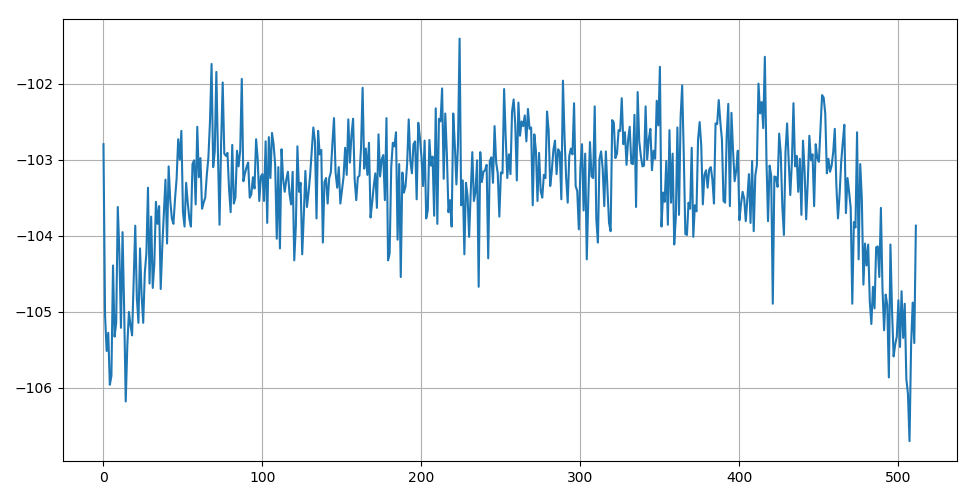

In [6]:
plot_fft(batch[163])